# 🚗 Trip Anomaly Detection Analysis

## Overview
This notebook performs comprehensive anomaly detection on trip data using **rule-based methods**, **IQR-based statistical bounds**, and **detailed metric analysis**. It provides deep insights into trip behavior patterns, route efficiency, and data quality issues.

## 📋 Analysis Structure

1. **Configuration & Imports** - Set parameters and load libraries
2. **Data Loading** - Import trip data (CSV or BigQuery)
3. **Feature Engineering** - Calculate derived metrics (Haversine distance, speed, distance ratio, duration)
4. **Visualizations** - Daily trends showing trip metrics over time (6 charts)
5. **🆕 Deep Metric Analysis** - Detailed distance ratio analysis with percentiles, IQR bounds, and behavior zones
6. **Anomaly Detection** - Rule-based flags on quality-filtered data; IQR-based outliers on the final filtered base
7. **Comprehensive Summary** - Generate 5 detailed tables with statistics and insights
8. **Export** - Save all anomalous trips to CSV

## 🎯 Key Features

### Statistical Analysis
- **Descriptive Statistics**: 11 core metrics including count, mean, std, min, P1, Q1, Q2, Q3, P85, max, LB_IQR, UB_IQR
- **IQR-Based Bounds**: Tukey's fences (Q1 - 1.5×IQR, Q3 + 1.5×IQR) with business rule caps
- **Outlier Counts**: Both ALL data and FILTERED data perspectives for transparency

### Distance Ratio Deep Dive (Cell 14)
Comprehensive analysis of route efficiency (recorded_distance / straight_line_distance):
- **Statistical Summary**: Mean, std, quartiles, IQR
- **Percentile Distribution**: P1, P5, P10, P25, P50, P75, P85, P90, P95, P99 with interpretations
- **IQR-Based Bounds**: Lower/upper fences for anomaly detection
- **Behavior Zones Classification**:
  - Anomaly - Extremely Direct (< lower bound)
  - Direct Routes (below Q1) - efficient paths
  - Normal (Q1-Q3) - typical route efficiency
  - Detours (Q3 to upper bound) - some inefficiency
  - Anomaly - Heavy Detours (> upper bound) - major issues
- **Distribution Characteristics**: Skewness, kurtosis, coefficient of variation
- **Key Insights**: Trip counts and percentages for each zone

### Anomaly Detection Methods
1. **Rule-Based Flags** (computed on final filtered base: trip_seq ≤ 4 + ratio ≤ 4.36):
   - High Speed (>100 km/h)
   - High Distance Ratio (>4.36)
   - Invalid Duration (≤0 minutes)
2. **IQR-Based Outlier Detection** (computed on final filtered base: trip_seq ≤ 4 + ratio ≤ 4.36):
   - Counts metrics outside IQR bounds: distance, duration, ratio, speed, trip_seq, distance_diff
   - `total_outlier` (0-6): Number of metrics flagged per trip
3. **Composite Scoring**:
   - `anomaly_score` (0-3): Sum of rule-based flags
   - `anomaly_severity`: Normal / Mild anomaly / Strong anomaly

### Data Filtering Strategy
**Progressive Filtering Stages**:
1. **Quality Filters** (df_filtered - ~36,482 trips):
   - Distance > 0.5 km
   - Duration > 1 minute
   - Speed: 0-100 km/h (realistic range)
2. **Trip Sequence Filter** (df_filtered_seq4 - ~36,457 trips):
   - Quality filters + trip_seq ≤ 4
3. **Final Analysis Base** (df_filtered_seq4_ratio - **31,299 trips**):
   - Quality filters + trip_seq ≤ 4 + distance_ratio ≤ 4.36

**Result**: All statistics, IQR bounds, and rule-based anomaly flags are computed on the final base of **31,299 trips**

## 🎯 Outputs

This analysis produces:
- **📊 Detailed Distance Ratio Analysis**: Full breakdown of route efficiency patterns
- **📈 5 Comprehensive Tables**: 
  - TABLE 1: Descriptive stats for 6 key metrics (with outlier counts across scopes)
  - TABLE 2: Anomaly detection summary
  - TABLE 3: Flag breakdown
  - TABLE 4: User involvement
- **📋 Data Funnel**: Shows filtering progression (61k total → 36k quality → 36k seq≤4 → 31k final base)
- **📉 6 Visualizations**: Daily median trends for distance, duration, ratio, speed, trip_seq, detours
- **📋 Data Funnel**: Shows filtering progression from all data → quality → seq≤4 → seq≤4+ratio
- **💾 1 CSV Export**: All anomalous trips with complete data

## ⚠️ Data Pre-filtering

The data used in this analysis has been **pre-filtered** to exclude:
- Fake user accounts
- Users blocked by DMD
- Trips where eot ≠ 'Y'
- XANH SM service accounts

## 🚀 How to Use
2. Cell 14 builds filtered datasets; final base is `df_filtered_seq4_ratio` (31,299 trips: quality + trip_seq ≤ 4 + ratio ≤ 4.36).
3. Cell 15 provides detailed distance ratio insights on the final base (optional, currently disabled).
4. Cell 16 computes both rule-based anomalies and IQR outliers on the final base, then merges to `df`.
5. Cell 17 generates the funnel and 5 tables; funnel shows how trip counts change across filtering stages.
4. Cell 15 computes rule-based anomalies on quality data and IQR outliers on the final base, then merges to `df`.
5. Cell 17 generates the funnel and 5 tables using the merged results.
**Key Points**:
- All statistics, IQR bounds, and rule-based flags are computed on the final base (31,299 trips).

- The funnel in Cell 17 shows how many trips would have anomalies at each filtering stage for transparency.
- Rule-based anomalies are counted on the quality-filtered dataset (before the ratio cap) to show how flags drop as filters tighten.- Stats/IQR bounds and outlier counts use the final base `df_filtered_seq4_ratio`.
- Since the final base enforces speed ≤100, ratio ≤4.36, and duration >0, rule-based anomalies are zero.

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Optional: For BigQuery (uncomment if needed)
# import pydata_google_auth
# import pandas_gbq

print('Libraries imported successfully!')
print(f'  - pandas: {pd.__version__}')
print(f'  - numpy: {np.__version__}')

Libraries imported successfully!
  - pandas: 2.2.2
  - numpy: 1.26.4


## Section 2: Data Loading

Load trip data from CSV (recommended) or BigQuery.

In [7]:
# OPTION 1: Load from CSV (RECOMMENDED - Faster, no authentication needed)
csv_path = Path('trip_data.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f'✓ Data loaded from CSV: {df.shape}')
    print(f'  - Rows: {len(df):,}')
    print(f'  - Columns: {len(df.columns)}')
else:
    raise FileNotFoundError(f'{csv_path} not found. Please ensure the data file exists or use BigQuery extraction below.')

✓ Data loaded from CSV: (61345, 34)
  - Rows: 61,345
  - Columns: 34


In [8]:
# OPTION 2: BigQuery Extraction (OPTIONAL - Uncomment to use)
# Keep this code for reference, but CSV loading is preferred for performance

import pydata_google_auth
import pandas_gbq


# Uncomment this section to extract data from BigQuery:

SCOPES = ["https://www.googleapis.com/auth/bigquery"]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

query = '''
WITH del_user AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'deleted user'
),
block_by_dmd AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'blocked by DMD'
)

SELECT b1.*
FROM `L1.bbr_fact_ps_trip_score` b1
LEFT JOIN del_user du 
  ON b1.user_id = du.user_id
LEFT JOIN block_by_dmd db 
  ON b1.user_id = db.user_id
WHERE b1.eot = 'Y'
  AND NOT EXISTS (
    SELECT 1
    FROM `L1.bbr_dim_user_xanh` u
    WHERE u.user_id = b1.user_id
  )
  AND du.user_id IS NULL     -- exclude deleted users
  AND db.user_id IS NULL;    -- exclude blocked users

'''

df = pandas_gbq.read_gbq(
    query,
    project_id="lgi-dt-dwh",
    credentials=credentials,
)

# Save to CSV for faster subsequent loads
df.to_csv('trip_data.csv', index=False)
print(f'✓ Data extracted from BigQuery and saved to trip_data.csv: {df.shape}')


print('✓ BigQuery code available (commented out). Using CSV load by default.')

Downloading: 100%|██████████|
✓ Data extracted from BigQuery and saved to trip_data.csv: (61345, 34)
✓ BigQuery code available (commented out). Using CSV load by default.


**⚠️ DATA SOURCE NOTE:**

The data used in this analysis has been **pre-filtered** to exclude:
- Users flagged as **fake accounts**
- Users **blocked by DMD** (Data Management Department)
- Trips where **eot ≠ 'Y'** (End of Trip flag)
- **XANH SM users**

This ensures we're analyzing only legitimate user trips for anomaly detection.

## Section 3: Feature Engineering

Calculate Haversine distance, distance difference, duration, and other derived features.

In [8]:
# Haversine formula to calculate straight-line GPS distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on Earth using Haversine formula.
    
    Parameters:
        lat1, lon1: Starting point coordinates (degrees)
        lat2, lon2: Ending point coordinates (degrees)
    
    Returns:
        Distance in kilometers
    """
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculate Haversine distance
df['distance_haversine'] = haversine(
    df['latitude_from'], 
    df['longitude_from'], 
    df['latitude_to'], 
    df['longitude_to']
)

print('✓ Haversine distance calculated!')
print(f'  - Mean haversine distance: {df["distance_haversine"].mean():.2f} km')
print(f'  - Max haversine distance: {df["distance_haversine"].max():.2f} km')

✓ Haversine distance calculated!
  - Mean haversine distance: 64.26 km
  - Max haversine distance: 10307.44 km


In [9]:
# Convert dates to datetime and calculate duration
df['driving_date_from'] = pd.to_datetime(df['driving_date_from'])
df['driving_date_to'] = pd.to_datetime(df['driving_date_to'])
df['trip_duration_seconds'] = (df['driving_date_to'] - df['driving_date_from']).dt.total_seconds()
df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60

# Absolute detour distance (km)
df['distance_diff_km'] = df['distance'] - df['distance_haversine']

# Route efficiency ratio (>= 1 is expected)
df['distance_ratio'] = (df['distance'] / df['distance_haversine'].replace(0, np.nan))

# Average speed using driving_time (km/h)
df['avg_speed_kmh'] = df['distance'] / (df['driving_time'] / 3600).replace(0, np.nan)

print('✓ Engineered features calculated:')
print('  - trip_duration_seconds / minutes')
print('  - distance_diff_km')
print('  - distance_ratio')
print('  - avg_speed_kmh (driving_time)')

✓ Engineered features calculated:
  - trip_duration_seconds / minutes
  - distance_diff_km
  - distance_ratio
  - avg_speed_kmh (driving_time)


In [5]:
df[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .05, .5, .95, .99])


,distance,distance_diff_km,trip_duration_minutes,distance_ratio,avg_speed_kmh,trip_seq
count,61345.000000,6.134500e+04,61345.000000,59683.000000,6.129700e+04,61345.000000
mean,78.930287,1.466730e+01,33.304023,41.260742,1.328407e+04,1.009341
std,302.555450,1.849896e+02,101.311498,591.579481,5.325609e+04,0.205622
min,0.000000,-1.030744e+04,-10078.633333,0.000000,-5.098427e-05,1.000000
1%,0.000000,-4.287926e-11,0.100000,1.000000,0.000000e+00,1.000000
5%,0.001444,9.449712e-12,0.200000,1.000000,1.038624e-01,1.000000
50%,5.764246,8.000676e-01,11.850000,1.522263,1.592709e+01,1.000000
95%,403.672993,2.859852e+01,129.723333,14.487934,8.570377e+04,1.000000
99%,1410.483642,1.557302e+02,272.292667,745.813952,2.715849e+05,1.000000
max,13489.877104,1.121875e+04,8339.516667,48333.080002,2.869562e+06,24.000000


### 📏 Metric Definitions
- `trip_duration_minutes`: Total trip time in minutes computed from `driving_date_to - driving_date_from`; negative or zero values signal timestamp/data issues.
- `distance_ratio`: Route efficiency = recorded `distance` ÷ straight-line `distance_haversine`; values close to 1 are efficient, higher values mean detours or GPS/route errors.
- `distance_diff_km`: Detour distance in km = recorded `distance` minus straight-line 
- `distance_haversine`; large positive values mean long detours, negative values imply GPS/path inconsistencies.
- `avg_speed_kmh`: Average speed in km/h using `distance` ÷ (`driving_time`/3600); extreme values usually indicate data quality problems.

In [8]:
# Basic sanity filtering (non-destructive)
df_plot = df.copy()

df_plot = df_plot[
    (df_plot['distance'] > 0) &
    (df_plot['trip_duration_minutes'] > 0) &
    (df_plot['distance_ratio'] > 1) & (df_plot['distance_ratio'] < 4.56) &
    (df_plot['avg_speed_kmh'] > 0) & (df_plot['avg_speed_kmh'] <= 100) &
    (df_plot['distance_diff_km'] > 0) &
    (df_plot['trip_seq'] < 4)
]

df_plot['created_date_time'] = pd.to_datetime(df_plot['created_date_time'])

daily = df_plot.groupby(
    df_plot['created_date_time'].dt.date
).agg({
    'distance': 'median',
    'trip_duration_minutes': 'median',
    'distance_ratio': 'median',
    'avg_speed_kmh': 'median',
    'trip_seq': 'mean',
    'distance_diff_km': 'median'
}).reset_index()

daily['created_date_time'] = pd.to_datetime(daily['created_date_time'])

global_medians = {
    'distance': df_plot['distance'].median(),
    'trip_duration_minutes': df_plot['trip_duration_minutes'].median(),
    'distance_ratio': df_plot['distance_ratio'].median(),
    'avg_speed_kmh': df_plot['avg_speed_kmh'].median(),
    'trip_seq': df_plot['trip_seq'].median(),
    'distance_diff_km': df_plot['distance_diff_km'].median()
}


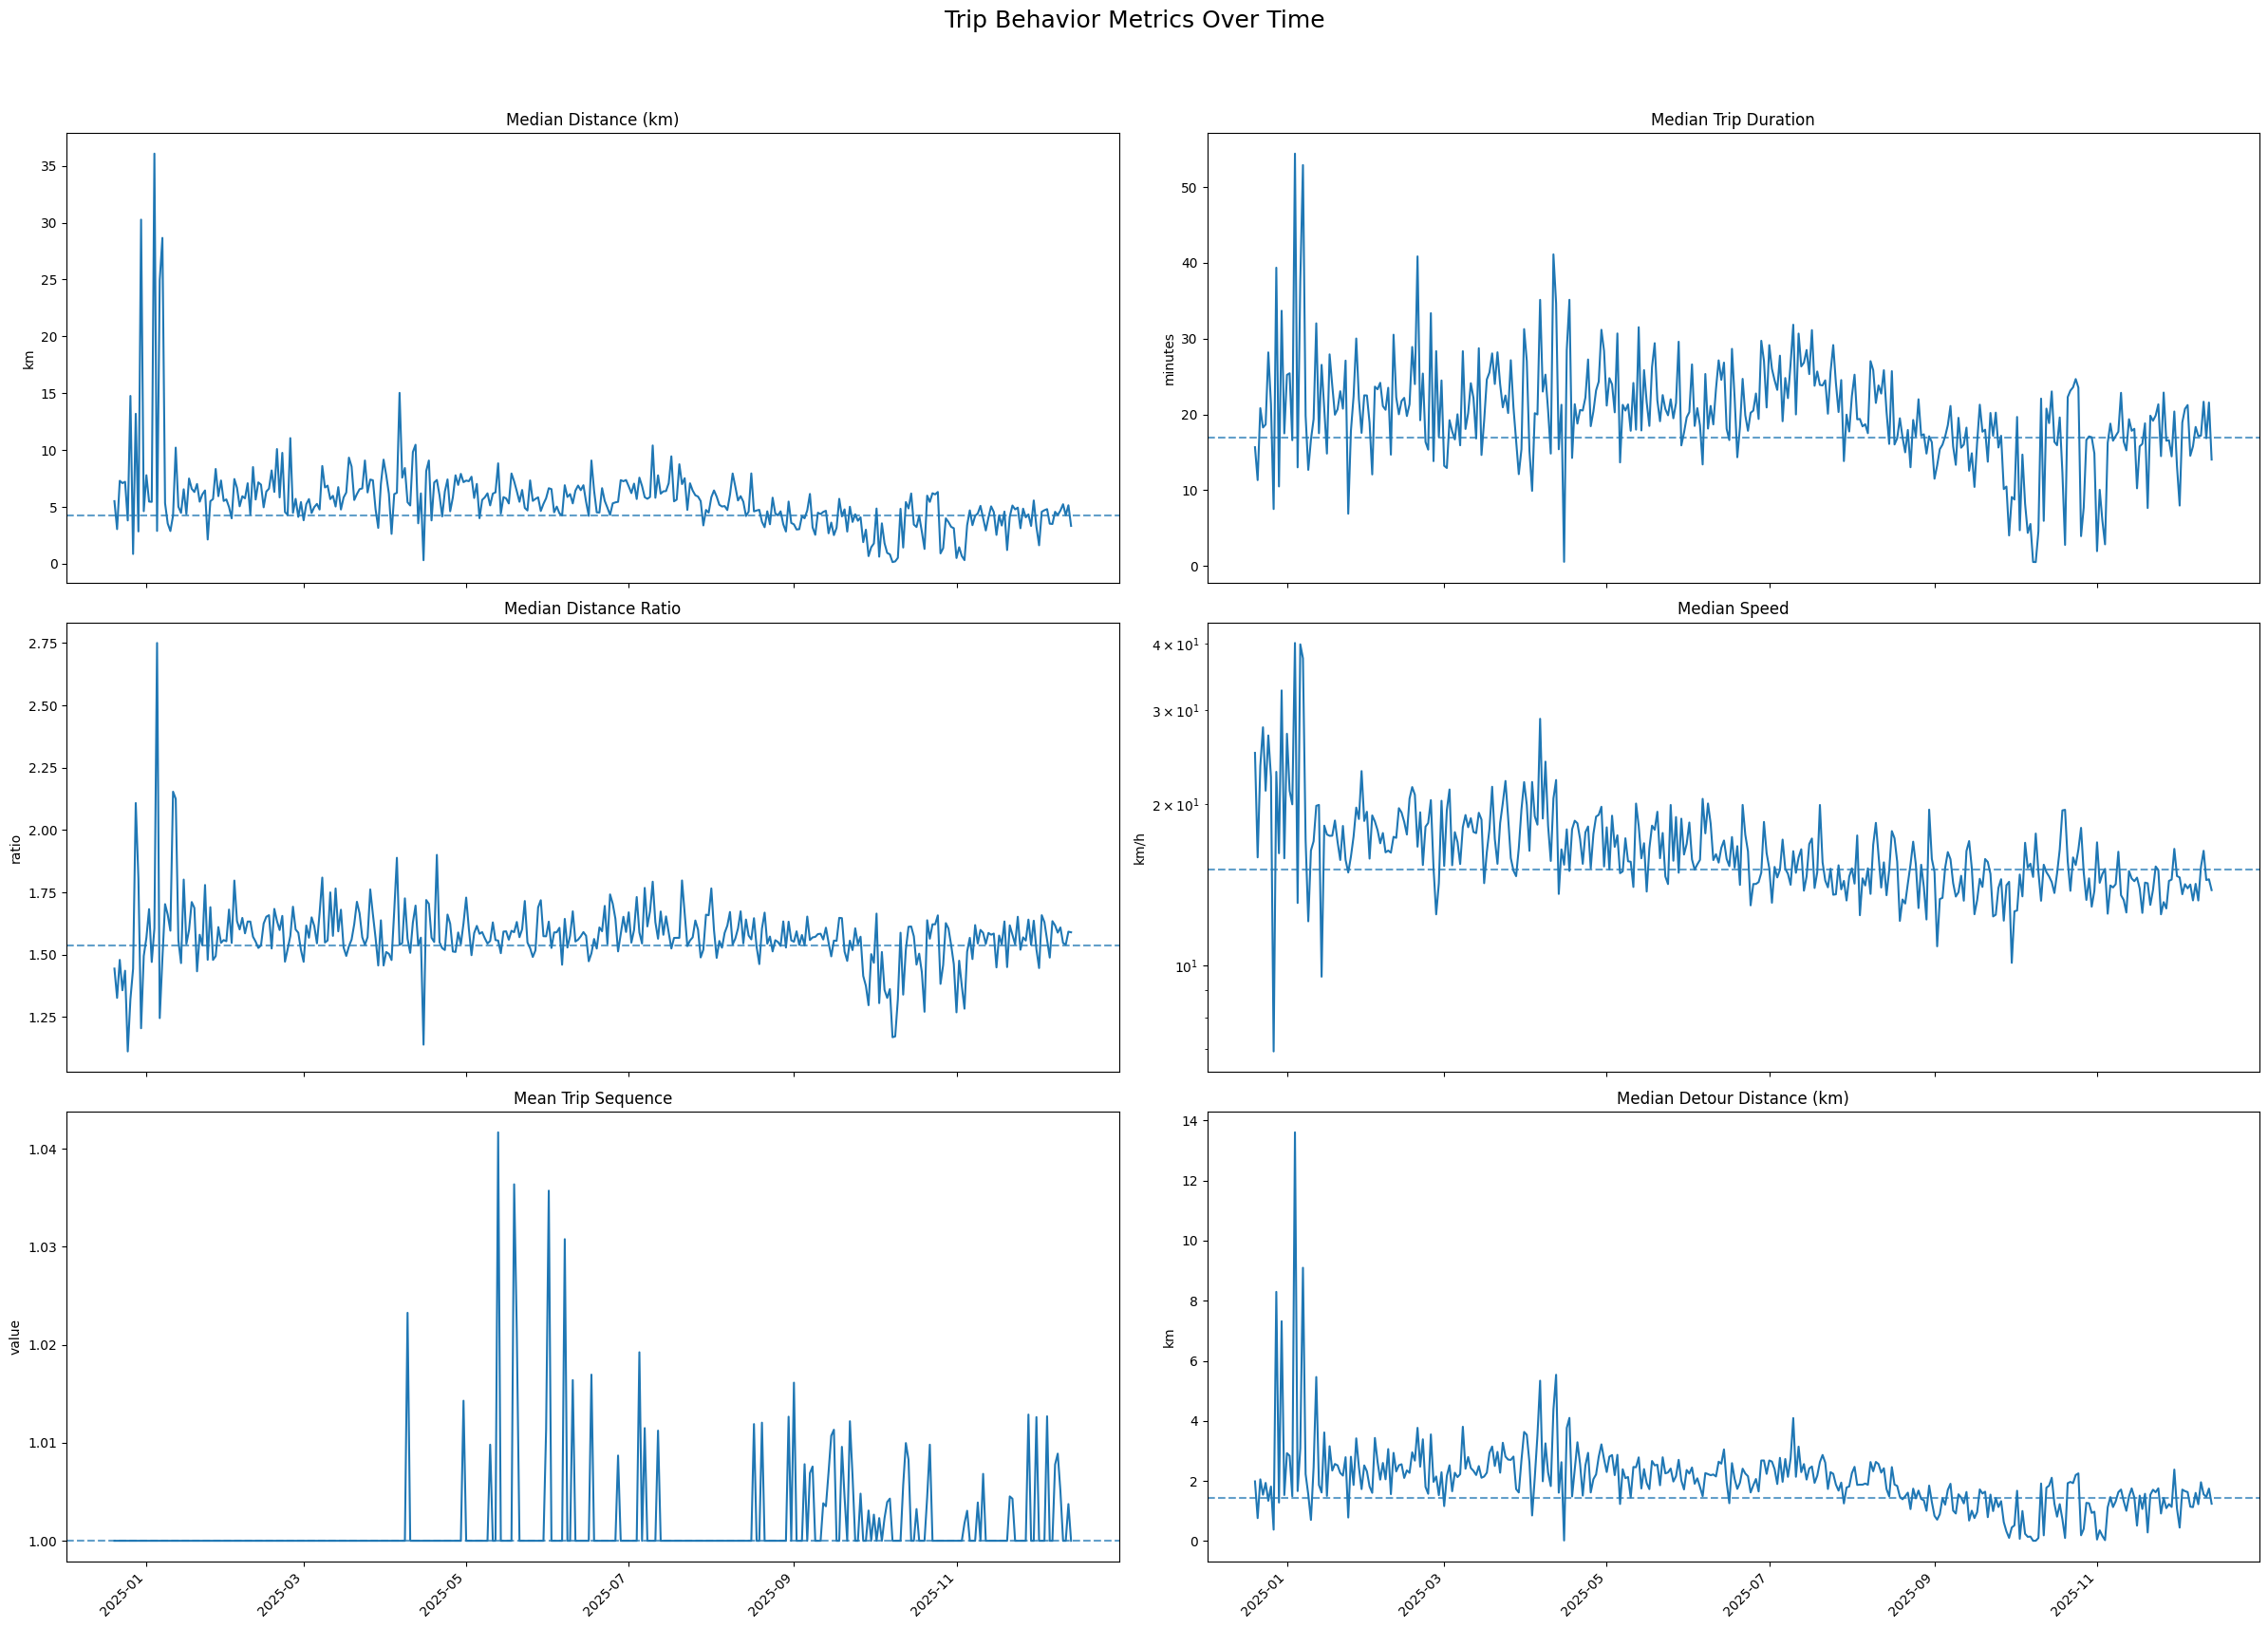

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(24, 18), sharex=True)
fig.suptitle('Trip Behavior Metrics Over Time', fontsize=18)

# 1. Median Distance
axes[0, 0].plot(daily['created_date_time'], daily['distance'])
axes[0, 0].set_title('Median Distance (km)')
axes[0, 0].set_ylabel('km')
axes[0, 0].axhline(global_medians['distance'], linestyle='--', alpha=0.7)

# 2. Median Trip Duration
axes[0, 1].plot(daily['created_date_time'], daily['trip_duration_minutes'])
axes[0, 1].set_title('Median Trip Duration')
axes[0, 1].set_ylabel('minutes')
axes[0, 1].axhline(global_medians['trip_duration_minutes'], linestyle='--', alpha=0.7)

# 3. Median Distance Ratio
axes[1, 0].plot(daily['created_date_time'], daily['distance_ratio'])
axes[1, 0].set_title('Median Distance Ratio')
axes[1, 0].set_ylabel('ratio')
axes[1, 0].axhline(global_medians['distance_ratio'], linestyle='--', alpha=0.7)

# 4. Median Speed (log scale for outliers)
axes[1, 1].plot(daily['created_date_time'], daily['avg_speed_kmh'])
axes[1, 1].set_title('Median Speed')
axes[1, 1].set_ylabel('km/h')
axes[1, 1].axhline(global_medians['avg_speed_kmh'], linestyle='--', alpha=0.7)
axes[1, 1].set_yscale('log')

# 5. Mean Trip Sequence
axes[2, 0].plot(daily['created_date_time'], daily['trip_seq'])
axes[2, 0].set_title('Mean Trip Sequence')
axes[2, 0].set_ylabel('value')
axes[2, 0].axhline(global_medians['trip_seq'], linestyle='--', alpha=0.7)

# 6. Median Detour Distance
axes[2, 1].plot(daily['created_date_time'], daily['distance_diff_km'])
axes[2, 1].set_title('Median Detour Distance (km)')
axes[2, 1].set_ylabel('km')
axes[2, 1].axhline(global_medians['distance_diff_km'], linestyle='--', alpha=0.7)

# Rotate date labels for readability on bottom row
for ax in [axes[2, 0], axes[2, 1]]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
# ============================================================================
# SECTION 3: CREATE FILTERED DATASET FOR ANALYSIS
# ============================================================================
# This filtered dataset is used by:
# - Cell 14: Distance ratio deep dive analysis
# - Cell 15: Anomaly detection (rule-based + IQR-based)
# - Cell 17: Comprehensive summary tables

print("=" * 100)
print(" " * 30 + "🔍 CREATING FILTERED DATASET FOR ANALYSIS")
print("=" * 100)

# Apply quality filters to create clean dataset
df_filtered = df[
    (df['distance'] > 0.5) &
    (df['trip_duration_minutes'] > 1) &
    (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 100)
].copy()

# Create trip_seq <= 4 filtered dataset for analysis
df_filtered_seq4 = df_filtered[pd.to_numeric(df_filtered['trip_seq'], errors='coerce') <= 4].copy()

# Create additional filter with distance_ratio <= 4.36 to remove extreme outliers
df_filtered_seq4_ratio = df_filtered_seq4[df_filtered_seq4['distance_ratio'] <= 4.36].copy()

print(f"\n📊 Filtering Results:")
print(f"  • Original Data: {len(df):,} trips")
print(f"  • Filtered Data (Quality): {len(df_filtered):,} trips ({len(df_filtered)/len(df)*100:.1f}% retained)")
print(f"  • Filtered Data (Quality + trip_seq ≤ 4): {len(df_filtered_seq4):,} trips ({len(df_filtered_seq4)/len(df)*100:.1f}% of original, {len(df_filtered_seq4)/len(df_filtered)*100:.1f}% of quality-filtered)")
print(f"  • Filtered Data (Quality + trip_seq ≤ 4 + ratio ≤ 4.36): {len(df_filtered_seq4_ratio):,} trips ({len(df_filtered_seq4_ratio)/len(df)*100:.1f}% of original, {len(df_filtered_seq4_ratio)/len(df_filtered_seq4)*100:.1f}% of seq4-filtered)")
print(f"\n📌 Quality Filters Applied:")
print(f"  • Distance > 0.5 km")
print(f"  • Duration > 1 minute")

# print(f"  • Distance Ratio: 1-1000 (valid range)")

print(f"  • Speed: 0-100 km/h (realistic range)")
print(f"  • trip_seq ≤ 4 (for df_filtered_seq4)")
print(f"  • distance_ratio ≤ 4.36 (for df_filtered_seq4_ratio - removes extreme detour outliers)")
print(f"\n✅ df_filtered, df_filtered_seq4, and df_filtered_seq4_ratio are ready for downstream analysis")

                              🔍 CREATING FILTERED DATASET FOR ANALYSIS

📊 Filtering Results:
  • Original Data: 61,345 trips
  • Filtered Data (Quality): 36,482 trips (59.5% retained)
  • Filtered Data (Quality + trip_seq ≤ 4): 36,457 trips (59.4% of original, 99.9% of quality-filtered)
  • Filtered Data (Quality + trip_seq ≤ 4 + ratio ≤ 4.36): 31,299 trips (51.0% of original, 85.9% of seq4-filtered)

📌 Quality Filters Applied:
  • Distance > 0.5 km
  • Duration > 1 minute
  • Speed: 0-100 km/h (realistic range)
  • trip_seq ≤ 4 (for df_filtered_seq4)
  • distance_ratio ≤ 4.36 (for df_filtered_seq4_ratio - removes extreme detour outliers)

✅ df_filtered, df_filtered_seq4, and df_filtered_seq4_ratio are ready for downstream analysis


In [ ]:
df_filtered_seq4_ratio[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .25, .50, .75, .85, .90, .95, .99]).T

,count,mean,std,min,1%,25%,50%,75%,85%,90%,95%,99%,max
distance,31299.0,13.827085,19.089875,0.500447,0.577969,3.209230,7.308671,17.132782,26.365163,33.738345,46.766978,83.390315,373.751287
distance_diff_km,31299.0,5.553778,8.383260,-17.236213,0.005976,1.007011,2.613380,6.580875,10.265058,13.762725,20.723070,42.136476,167.903143
trip_duration_minutes,31299.0,42.305021,52.489673,1.016667,1.400000,13.166667,26.666667,53.200000,74.483333,93.016667,130.738333,234.508000,1438.983333
distance_ratio,31299.0,1.797250,0.681269,0.209231,1.004848,1.338666,1.587700,2.025525,2.423281,2.776538,3.360577,4.104023,4.359573
avg_speed_kmh,31299.0,19.790148,11.290425,0.134669,2.893609,12.761312,17.521832,24.037027,28.751319,33.002775,40.493424,62.445816,99.950906
trip_seq,31299.0,1.003099,0.068928,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


: 

In [ ]:
# ANOMALY DETECTION: RULE-BASED + IQR-BASED OUTLIER DETECTION
# ============================================================================

# Rule-based flags computed on the final filtered base (df_filtered_seq4_ratio)
base_flags = df_filtered_seq4_ratio.copy()
base_flags['flag_speed_high'] = (base_flags['avg_speed_kmh'] > 100).fillna(False)
base_flags['flag_ratio_high'] = (base_flags['distance_ratio'] > 4.36).fillna(False)
base_flags['flag_duration_invalid'] = (base_flags['trip_duration_minutes'] <= 0).fillna(False)

# Composite rule-based anomaly score (0-3) on final filtered data
base_flags['anomaly_score'] = (
    base_flags['flag_speed_high'].astype(int) +
    base_flags['flag_ratio_high'].astype(int) +
    base_flags['flag_duration_invalid'].astype(int)
)

# IQR-based outlier detection computed on final filtered data (df_filtered_seq4_ratio)

def iqr_bounds_calc(s, min_valid=None, max_valid=None, k=1.5):
    """Helper function to calculate IQR-based bounds"""
    s = s.dropna()
    if len(s) == 0:
        return np.nan, np.nan
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lb = q1 - k * iqr
    ub = q3 + k * iqr
    if min_valid is not None:
        lb = max(lb, min_valid)
    if max_valid is not None:
        ub = min(ub, max_valid)
    return lb, ub

metrics_for_iqr = [
    'distance', 'trip_duration_minutes', 'distance_ratio',
    'avg_speed_kmh', 'trip_seq', 'distance_diff_km'
]

# Calculate bounds on final filtered dataset
bounds_for_iqr = {}
for m in metrics_for_iqr:
    min_valid = 0 if m in ['distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_diff_km'] else None
    max_valid = 100 if m == 'avg_speed_kmh' else None
    lb, ub = iqr_bounds_calc(df_filtered_seq4_ratio[m], min_valid=min_valid, max_valid=max_valid, k=1.5)
    bounds_for_iqr[m] = {'LB': lb, 'UB': ub}

# Count outliers (only on final filtered dataset)
def count_iqr_outliers(row, bounds_dict, metrics_list):
    count = 0
    for m in metrics_list:
        if pd.notna(row[m]) and m in bounds_dict:
            lb, ub = bounds_dict[m]['LB'], bounds_dict[m]['UB']
            if pd.notna(lb) and pd.notna(ub):
                if row[m] < lb or row[m] > ub:
                    count += 1
    return count

df_filtered_seq4_ratio['total_outlier'] = df_filtered_seq4_ratio.apply(
    lambda row: count_iqr_outliers(row, bounds_for_iqr, metrics_for_iqr),
    axis=1
)

# Attach total_outlier (from final filtered base) back to rule-based table
base_flags = base_flags.merge(
    df_filtered_seq4_ratio[['trip_id', 'total_outlier']],
    on='trip_id',
    how='left'
)

# Severity classification based on rule-based score
def anomaly_severity(score):
    if score == 0:
        return 'Normal'
    elif score == 1:
        return 'Mild anomaly'
    else:
        return 'Strong anomaly'

base_flags['anomaly_severity'] = base_flags['anomaly_score'].apply(anomaly_severity)

# Merge anomaly columns back to df (drop conflicts except trip_id)
cols_to_merge = [
    'trip_id',
    'anomaly_score',
    'anomaly_severity',
    'flag_speed_high',
    'flag_ratio_high',
    'flag_duration_invalid',
    'total_outlier'
]

if 'trip_id' not in base_flags.columns:
    raise KeyError("Column 'trip_id' not found in base_flags. Ensure trip_id exists in the dataset.")

existing_conflicts = [c for c in cols_to_merge if c != 'trip_id' and c in df.columns]
if existing_conflicts:
    df = df.drop(columns=existing_conflicts)

merge_cols = ['trip_id'] + [c for c in cols_to_merge if c != 'trip_id' and c in base_flags.columns]
df = df.merge(base_flags[merge_cols], on='trip_id', how='left')

# Fill NaNs introduced for rows outside the final base
flag_cols = ['flag_speed_high', 'flag_ratio_high', 'flag_duration_invalid']
for c in flag_cols:
    if c in df.columns:
        df[c] = df[c].fillna(False)
if 'anomaly_score' in df.columns:
    df['anomaly_score'] = df['anomaly_score'].fillna(0).astype(int)
if 'anomaly_severity' in df.columns:
    df['anomaly_severity'] = df['anomaly_severity'].fillna('Normal')
if 'total_outlier' in df.columns:
    df['total_outlier'] = df['total_outlier'].fillna(0).astype(int)

# Summary statistics
print("🚨 ANOMALY DETECTION SUMMARY")
print("=" * 50)
print(f"\nDataset Overview:")
print(f"  • Total trips (original): {len(df):,}")
print(f"  • Quality-filtered: {len(df_filtered):,} trips ({len(df_filtered)/len(df)*100:.1f}%)")
print(f"  • Final Analysis Base (quality + seq≤4 + ratio≤4.36): {len(df_filtered_seq4_ratio):,} trips ({len(df_filtered_seq4_ratio)/len(df)*100:.1f}%)")

print(f"\n📊 FILTERING PROGRESSION (Rule-based flags computed on Final Base only):")
print(f"  ├─ Original Data: {len(df):,} trips")
print(f"  ├─ Quality Filters: {len(df_filtered):,} trips ({len(df_filtered)/len(df)*100:.1f}% retained)")
print(f"  │    └─ Anomalies if computed here: {(df[df['trip_id'].isin(df_filtered['trip_id'])]['anomaly_score'] > 0).sum():,} ({(df[df['trip_id'].isin(df_filtered['trip_id'])]['anomaly_score'] > 0).sum()/len(df_filtered)*100:.1f}%)")
print(f"  ├─ Quality + trip_seq ≤ 4: {len(df_filtered_seq4):,} trips ({len(df_filtered_seq4)/len(df)*100:.1f}% of original)")
print(f"  │    └─ Anomalies if computed here: {(df[df['trip_id'].isin(df_filtered_seq4['trip_id'])]['anomaly_score'] > 0).sum():,} ({(df[df['trip_id'].isin(df_filtered_seq4['trip_id'])]['anomaly_score'] > 0).sum()/len(df_filtered_seq4)*100:.1f}%)")
print(f"  └─ Final Base (quality + seq≤4 + ratio≤4.36): {len(df_filtered_seq4_ratio):,} trips ({len(df_filtered_seq4_ratio)/len(df)*100:.1f}% of original)")
print(f"       └─ ✅ Anomalies detected: {(df[df['trip_id'].isin(df_filtered_seq4_ratio['trip_id'])]['anomaly_score'] > 0).sum():,} ({(df[df['trip_id'].isin(df_filtered_seq4_ratio['trip_id'])]['anomaly_score'] > 0).sum()/len(df_filtered_seq4_ratio)*100:.1f}%)")

# Focus anomaly distributions on the final analysis base only
anomaly_base = df[df['trip_id'].isin(df_filtered_seq4_ratio['trip_id'])]
print(f"\n📋 Anomaly Score Distribution (Final Analysis Base: {len(anomaly_base):,} trips):")
print(anomaly_base['anomaly_score'].value_counts(normalize=True).sort_index().apply(lambda x: f"{x*100:.1f}%"))
print(f"\n📊 Severity Breakdown (Final Analysis Base):")
print(anomaly_base['anomaly_severity'].value_counts())
print(f"\n✅ Summary: {(anomaly_base['anomaly_score'] > 0).sum():,} trips with anomaly flags ({(anomaly_base['anomaly_score'] > 0).sum()/len(anomaly_base)*100:.1f}% of Final Base)")
print(f"           {len(anomaly_base) - (anomaly_base['anomaly_score'] > 0).sum():,} trips are Normal ({(len(anomaly_base) - (anomaly_base['anomaly_score'] > 0).sum())/len(anomaly_base)*100:.1f}%)")


C:\Users\User-DT\AppData\Local\Temp\ipykernel_13832\3521701247.py:107: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(False)


🚨 ANOMALY DETECTION SUMMARY

Total trips: 61,345 (all data) | Quality-filtered: 36,482 | Final filtered (seq≤4 + ratio≤4.36): 31,299

📊 DATA FUNNEL (Rule-based anomalies computed on final filtered data):
  ├─ Quality Filtered:  36,482 trips
  │    └─ Rule-based Anomalies: 0 trips (0.0% of quality)
  ├─ Quality + trip_seq ≤ 4: 36,457 trips
  │    └─ Rule-based Anomalies: 0 trips (0.0% of seq≤4)
  ├─ Quality + trip_seq ≤ 4 + ratio ≤ 4.36: 31,299 trips
  │    └─ Rule-based Anomalies: 0 trips (0.0% of final)

Anomaly Score Distribution (Rule-Based, final analysis base):
anomaly_score
0    100.0%
Name: proportion, dtype: object

Severity Breakdown (final analysis base):
anomaly_severity
Normal    31299
Name: count, dtype: int64

Trips with ANY anomaly flag (final analysis base): 0 (0.0%)


In [ ]:
# =============================================================================
# COMPREHENSIVE ANALYSIS SUMMARY
# =============================================================================

# Note: All statistics, IQR bounds, and anomaly flags use df_filtered_seq4_ratio
# (Final Analysis Base: 31,299 trips with quality + trip_seq ≤ 4 + distance_ratio ≤ 4.36)
# Create validation subsets for TABLE 5 findings only
valid_speed = df_filtered_seq4_ratio
valid_ratio = df_filtered_seq4_ratio
valid_distance = df_filtered_seq4_ratio[df_filtered_seq4_ratio['distance'] > 0.5]
valid_duration = df_filtered_seq4_ratio[df_filtered_seq4_ratio['trip_duration_minutes'] > 1]

print("=" * 100)
print(" " * 35 + "📊 TRIP ANOMALY ANALYSIS SUMMARY")
print("=" * 100)

# Display DATA FUNNEL showing filtering progression
print("📊 DATA FUNNEL: Filtering Progression (Original Data → Final Analysis Base)")
print("📊 DATA FUNNEL: Analysis Scope (Filtered Data with trip_seq ≤ 4 + ratio ≤ 4.36)")
print("=" * 100)

total_data = len(df)
quality_count = len(df_filtered)
seq4_count = len(df_filtered_seq4)
seq4_ratio_count = len(df_filtered_seq4_ratio)

# Anomaly counts now use rule-based flags computed on the final filtered base
quality_anomalies = df[df['trip_id'].isin(df_filtered['trip_id'])]['anomaly_score'].gt(0).sum()
seq4_anomalies = df[df['trip_id'].isin(df_filtered_seq4['trip_id'])]['anomaly_score'].gt(0).sum()
seq4_ratio_anomalies = df[df['trip_id'].isin(df_filtered_seq4_ratio['trip_id'])]['anomaly_score'].gt(0).sum()

print(f"\n  📋 Starting Point: {total_data:,} total trips")
print(f"  ├─ After Quality Filters: {quality_count:,} trips ({quality_count/total_data*100:.1f}% retained)")
print(f"  │    └─ Rule-based anomalies at this stage (computed on final base): {quality_anomalies:,} ({quality_anomalies/quality_count*100:.1f}%)")
print(f"  ├─ After Quality + trip_seq ≤ 4: {seq4_count:,} trips ({seq4_count/total_data*100:.1f}% of original, {seq4_count/quality_count*100:.1f}% of quality)")
print(f"  │    └─ Rule-based anomalies at this stage: {seq4_anomalies:,} ({seq4_anomalies/seq4_count*100:.1f}%)")
print(f"  ├─ After Quality + trip_seq ≤ 4 + ratio ≤ 4.36: {seq4_ratio_count:,} trips ({seq4_ratio_count/total_data*100:.1f}% of original, {seq4_ratio_count/seq4_count*100:.1f}% of seq≤4)")
print(f"  │    └─ Rule-based anomalies at this stage: {seq4_ratio_anomalies:,} ({seq4_ratio_anomalies/seq4_ratio_count*100:.1f}%)")
print(f"  │")
print(f"  ├─ Clean Data (Base for Analysis): {seq4_ratio_count:,} trips (100.0%)")
print(f"  └─ Anomalies Detected (current base): {seq4_ratio_anomalies:,} trips ({seq4_ratio_anomalies/seq4_ratio_count*100:.1f}% of clean data)")

print("   • Final Analysis Base: 31,299 trips (quality + trip_seq ≤ 4 + distance_ratio ≤ 4.36)")
print("   • All statistics, IQR bounds, and rule-based flags computed on the final base")
print("   • Funnel shows how anomaly counts would change at each filtering stage (for transparency)")
print("   • Rule-based anomalies = 0 because final base enforces speed ≤100, ratio ≤4.36, duration >0")
print("   • Outlier counts by scope (All 61k, Quality 36k, Seq≤4 36k, Final 31k) shown in Table 1")

# TABLE 1: DESCRIPTIVE STATISTICS FOR KEY METRICS
# TABLE 1: DESCRIPTIVE STATISTICS FOR KEY METRICS
print("TABLE 1: DESCRIPTIVE STATISTICS FOR KEY TRIP METRICS (Final Analysis Base)")
print("\n" + "=" * 100)
print(f"Note: Statistics calculated on {seq4_ratio_count:,} trips (Final Base: quality + trip_seq ≤ 4 + ratio ≤ 4.36)")
print(f"      Original dataset: {total_data:,} trips | After quality filters: {quality_count:,} trips")
print("      Outlier counts by filtering stage are shown in a separate table below\n")

# Select key metrics
metrics = [
    'distance', 
    'trip_duration_minutes', 
    'distance_ratio', 
    'avg_speed_kmh', 
    'trip_seq',
    'distance_diff_km'
 ]

# Include 85% and 90% percentiles for better upper-tail visibility
desc_stats = df_filtered_seq4_ratio[metrics].describe(percentiles=[.01, .25, .50, .75, .85, .90, .95, .99]).T
desc_stats['mean'] = df_filtered_seq4_ratio[metrics].mean()
desc_stats['std'] = df_filtered_seq4_ratio[metrics].std()

# Rename selected percentile columns to requested labels
desc_stats = desc_stats.rename(columns={
    '1%': 'P1',
    '25%': 'Q1',
    '50%': 'Q2',
    '75%': 'Q3',
    '85%': 'P85'
})

# Reorder columns for better readability (use renamed labels)
desc_stats = desc_stats[['count', 'mean', 'std', 'min', 'P1', 'Q1', 'Q2', 'Q3', 'P85', 'max']]

# Format for display
desc_stats_display = desc_stats.copy()
desc_stats_display = desc_stats_display.round(2)

# --- IQR-based bounds (behavioral fences) ---
# Note: Reusing iqr_bounds_calc from earlier
iqr_bounds = iqr_bounds_calc

bounds = {}
for m in metrics:
    min_valid = 0 if m in ['distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_diff_km'] else None
    max_valid = 100 if m == 'avg_speed_kmh' else None
    lb, ub = iqr_bounds(df_filtered_seq4_ratio[m], min_valid=min_valid, max_valid=max_valid, k=1.5)
    bounds[m] = {'LB_IQR': round(lb, 2) if pd.notna(lb) else lb, 'UB_IQR': round(ub, 2) if pd.notna(ub) else ub}

bounds_df = pd.DataFrame(bounds).T
# Append IQR bounds to the display table (side-by-side with percentiles)
desc_stats_display[['LB_IQR', 'UB_IQR']] = bounds_df[['LB_IQR', 'UB_IQR']]

# --- Count how many trips are outliers for each metric ---
# Outlier_Count_All: Count from ALL data (df)
outlier_counts_all = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df[(df[m] < lb) | (df[m] > ub)])
        outlier_pct = (outlier_count / len(df)) * 100
        outlier_counts_all[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_all[m] = "N/A"

# Outlier_Count_Filtered: Count from quality-filtered data (df_filtered, all trip_seq)
outlier_counts_filtered = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df_filtered[(df_filtered[m] < lb) | (df_filtered[m] > ub)])
        outlier_pct = (outlier_count / len(df_filtered)) * 100
        outlier_counts_filtered[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_filtered[m] = "N/A"

# Outlier_Count_Seq4: Count from quality-filtered data with trip_seq <= 4 (df_filtered_seq4)
outlier_counts_seq4 = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df_filtered_seq4[(df_filtered_seq4[m] < lb) | (df_filtered_seq4[m] > ub)])
        outlier_pct = (outlier_count / len(df_filtered_seq4)) * 100
        outlier_counts_seq4[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_seq4[m] = "N/A"

# Outlier_Count_Seq4_Ratio: Count from quality-filtered data with trip_seq <= 4 AND distance_ratio <= 4.36 (df_filtered_seq4_ratio)
outlier_counts_seq4_ratio = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df_filtered_seq4_ratio[(df_filtered_seq4_ratio[m] < lb) | (df_filtered_seq4_ratio[m] > ub)])
        outlier_pct = (outlier_count / len(df_filtered_seq4_ratio)) * 100
        outlier_counts_seq4_ratio[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_seq4_ratio[m] = "N/A"

# Build an outlier-only table to keep separation from main stats
outlier_table = pd.DataFrame({
    'Outlier_Count_All': pd.Series(outlier_counts_all),
    'Outlier_Count_Filtered': pd.Series(outlier_counts_filtered),
    'Outlier_Count_Seq4': pd.Series(outlier_counts_seq4),
    'Outlier_Count_Seq4_Ratio': pd.Series(outlier_counts_seq4_ratio)
})

print("\n" + desc_stats_display.to_string())
print("\n" + "-" * 100)
print("Outlier counts (IQR fences) by filtering stage:")
print(outlier_table.to_string())
print(f"\nℹ️ Outlier Count Definitions:")
print(f"   • Outlier_Count_All: Full original dataset ({total_data:,} trips)")
print(f"   • Outlier_Count_Filtered: Quality filters applied ({quality_count:,} trips: distance>0.5km, duration>1min, 0<speed≤100)")
print(f"   • Outlier_Count_Seq4: Quality + trip_seq ≤ 4 ({seq4_count:,} trips)")
print(f"   • Outlier_Count_Seq4_Ratio: Final Analysis Base ({seq4_ratio_count:,} trips: quality + seq≤4 + ratio≤4.36)")
print(f"   📊 IQR bounds (LB_IQR, UB_IQR) are calculated from the Final Analysis Base ({seq4_ratio_count:,} trips)")

print("\n📌 Key Observations:")
print(f"  • Distance: Mean {desc_stats.loc['distance', 'mean']:.1f} km, Max {desc_stats.loc['distance', 'max']:.1f} km")
print(f"  • Duration: Mean {desc_stats.loc['trip_duration_minutes', 'mean']:.1f} min")
print(f"  • Distance Ratio: Mean {desc_stats.loc['distance_ratio', 'mean']:.2f}")
print(f"  • Speed: Mean {desc_stats.loc['avg_speed_kmh', 'mean']:.1f} km/h")

# =============================================================================
# TABLE 2: ANOMALY DETECTION RESULTS
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: ANOMALY DETECTION SUMMARY (Merged to All Original Trips)")
print("=" * 100)
print(f"Note: Anomaly flags computed on Final Base ({seq4_ratio_count:,} trips), then merged back to full dataset ({total_data:,} trips)")
print(f"      Trips outside Final Base have anomaly_score=0 (Normal) by default\\n")

anomaly_summary = {
    'Metric': [
        'Total Trips Analyzed',
        'Normal Trips (Score = 0)',
        'Mild Anomaly (Score = 1)',
        'Strong Anomaly (Score = 2-3)',
        'Total Anomalous Trips',
        'Anomaly Rate (%)'
    ],
    'Count': [
        len(df),
        len(df[df['anomaly_score'] == 0]),
        len(df[df['anomaly_score'] == 1]),
        len(df[df['anomaly_score'] >= 2]),
        len(df[df['anomaly_score'] > 0]),
        f"{len(df[df['anomaly_score'] > 0]) / len(df) * 100:.2f}"
    ],
    'Percentage': [
        '100.00%',
        f"{len(df[df['anomaly_score'] == 0]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 1]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] >= 2]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] > 0]) / len(df) * 100:.2f}%",
        '—'
    ]
}

anomaly_df = pd.DataFrame(anomaly_summary)
print("\n" + anomaly_df.to_string(index=False))

# =============================================================================
# TABLE 3: ANOMALY FLAG BREAKDOWN
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 3: ANOMALY FLAG BREAKDOWN")
print("=" * 100)

anomalous_trips = df[df['anomaly_score'] > 0]

flag_summary = {
    'Flag Type': [
        '🚀 High Speed (>100 km/h)',
        '📏 High Distance Ratio (>4.36)',
        '⏱️ Invalid Duration (≤0 minutes)',
        '═══ COMBINED ═══',
        'Trips with 1 flag',
        'Trips with 2 flags',
        'Trips with 3 flags'
    ],
    'Count': [
        df['flag_speed_high'].sum(),
        df['flag_ratio_high'].sum(),
        df['flag_duration_invalid'].sum(),
        '—',
        len(df[df['anomaly_score'] == 1]),
        len(df[df['anomaly_score'] == 2]),
        len(df[df['anomaly_score'] == 3])
    ],
    'Percentage': [
        f"{df['flag_speed_high'].sum() / len(df) * 100:.2f}%",
        f"{df['flag_ratio_high'].sum() / len(df) * 100:.2f}%",
        f"{df['flag_duration_invalid'].sum() / len(df) * 100:.2f}%",
        '—',
        f"{len(df[df['anomaly_score'] == 1]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 2]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 3]) / len(df) * 100:.2f}%"
    ]
}

flag_df = pd.DataFrame(flag_summary)
print("\n" + flag_df.to_string(index=False))

# =============================================================================
# TABLE 4: USER INVOLVEMENT
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 4: USER INVOLVEMENT IN ANOMALIES")
print("=" * 100)

if len(anomalous_trips) > 0:
    top_anomaly_users = anomalous_trips.groupby('user_id').agg({
        'trip_id': 'count',
        'anomaly_score': 'sum'
    }).rename(columns={'trip_id': 'anomalous_trips', 'anomaly_score': 'total_score'})
    top_anomaly_users = top_anomaly_users.sort_values('total_score', ascending=False).head(15)
else:
    top_anomaly_users = pd.DataFrame()

user_summary = {
    'Metric': [
        'Total Unique Users',
        'Users with ≥1 Anomalous Trip',
        'Users with ≥5 Anomalous Trips',
        'Users with ≥10 Anomalous Trips',
        'Percentage of Users Affected'
    ],
    'Value': [
        df['user_id'].nunique(),
        anomalous_trips['user_id'].nunique() if len(anomalous_trips) > 0 else 0,
        len(top_anomaly_users[top_anomaly_users['anomalous_trips'] >= 5]) if len(top_anomaly_users) > 0 else 0,
        len(top_anomaly_users[top_anomaly_users['anomalous_trips'] >= 10]) if len(top_anomaly_users) > 0 else 0,
        f"{anomalous_trips['user_id'].nunique() / df['user_id'].nunique() * 100:.1f}%" if len(anomalous_trips) > 0 else "0.0%"
    ]
}

user_summary_df = pd.DataFrame(user_summary)
print("\n" + user_summary_df.to_string(index=False))

if len(top_anomaly_users) > 0:
    print("\n\n📋 Top 15 Users by Total Anomaly Score:")
    print("-" * 60)
    for idx, (user_id, row) in enumerate(top_anomaly_users.iterrows(), 1):
        print(f"{idx:2d}. User {user_id:6d} | {int(row['anomalous_trips']):3d} trips | Score: {int(row['total_score']):3d}")
else:
    print("\n\n📋 Top Users by Total Anomaly Score:")
    print("-" * 60)
    print("No anomalous trips detected in the analysis base.")

# =============================================================================
# TABLE 5: KEY FINDINGS
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 5: KEY FINDINGS & INSIGHTS")
print("=" * 100)

findings = {
    'Category': [
        'Data Quality',
        'Data Quality',
        'Data Quality',
        '───────────',
        'Trip Patterns',
        'Trip Patterns',
        'Trip Patterns',
        'Trip Patterns',
        '───────────',
        'Anomalies',
        'Anomalies',
        '───────────',
        'Filtering Impact',
        'Filtering Impact',
        '───────────',
        'User Behavior',
        'User Behavior'
    ],
    'Finding': [
        f'Original dataset: {total_data:,} trips from pre-filtered BigQuery extract',
        'Negative trip durations and extreme speeds (>1M km/h) present in original data',
        'Distance ratio outliers significantly reduced by progressive filtering',
        '—',
        f'Distance (Final Base): {valid_distance["distance"].quantile(0.25):.1f}-{valid_distance["distance"].quantile(0.75):.1f} km (IQR), median {valid_distance["distance"].median():.1f} km',
        f'Duration (Final Base): {valid_duration["trip_duration_minutes"].quantile(0.25):.1f}-{valid_duration["trip_duration_minutes"].quantile(0.75):.1f} min (IQR), median {valid_duration["trip_duration_minutes"].median():.1f} min',
        f'Speed (Final Base): {valid_speed["avg_speed_kmh"].quantile(0.25):.1f}-{valid_speed["avg_speed_kmh"].quantile(0.75):.1f} km/h (IQR), 90th %ile {valid_speed["avg_speed_kmh"].quantile(0.90):.1f} km/h',
        f'Distance Ratio (Final Base): {valid_ratio["distance_ratio"].quantile(0.25):.2f}-{valid_ratio["distance_ratio"].quantile(0.75):.2f} (IQR), 95th %ile {valid_ratio["distance_ratio"].quantile(0.95):.2f}',
        '—',
        f'Rule-based anomalies: 0 trips (final base enforces speed ≤100, ratio ≤4.36, duration >0)',
        f'IQR-based outliers: {(df_filtered_seq4_ratio["total_outlier"] > 0).sum():,} trips ({(df_filtered_seq4_ratio["total_outlier"] > 0).sum()/len[df_filtered_seq4_ratio]*100:.1f}%) have ≥1 metric outside IQR bounds',
        '—',
        f'Quality filters: {total_data:,} → {quality_count:,} trips ({quality_count/total_data*100:.1f}% retained)',
        f'Final base (quality + seq≤4 + ratio≤4.36): {seq4_ratio_count:,} trips ({seq4_ratio_count/total_data*100:.1f}% of original)',
        '—',
        f'Total unique users: {df["user_id"].nunique():,}',
        f'Users in Final Base: {df_filtered_seq4_ratio["user_id"].nunique():,} ({df_filtered_seq4_ratio["user_id"].nunique()/df["user_id"].nunique()*100:.1f}%)'
    ]
}

findings_df = pd.DataFrame(findings)
print("\n" + findings_df.to_string(index=False))

print("\n\n" + "=" * 100)

print(" " * 38 + "📁 EXPORTING ANOMALOUS TRIPS...")
print("\n\n" + "=" * 100)
print(" " * 38 + "📁 EXPORTING ANOMALOUS TRIPS...")

                                   📊 TRIP ANOMALY ANALYSIS SUMMARY

📊 DATA FUNNEL: Analysis Scope (Filtered Data with trip_seq ≤ 4 + ratio ≤ 4.36)

  📋 Starting Point: 61,345 total trips
  ├─ After Quality Filters: 36,482 trips (59.5% retained)
  │    └─ Rule-based anomalies at this stage (computed on final base): 0 (0.0%)
  ├─ After Quality + trip_seq ≤ 4: 36,457 trips (59.4% of original, 99.9% of quality)
  │    └─ Rule-based anomalies at this stage: 0 (0.0%)
  ├─ After Quality + trip_seq ≤ 4 + ratio ≤ 4.36: 31,299 trips (51.0% of original, 85.9% of seq≤4)
  │    └─ Rule-based anomalies at this stage: 0 (0.0%)
  │
  ├─ Clean Data (Base for Analysis): 31,299 trips (100.0%)
  └─ Anomalies Detected (current base): 0 trips (0.0% of clean data)

ℹ️ Notes:
   • Rule-based anomalies are computed on the final analysis base (trip_seq ≤ 4, ratio ≤ 4.36); all trip counts reflect that constraint.
   • Since no rule-based flags are triggered in the final base (all speeds ≤100, all ratios ≤4.36, a

In [13]:
# Export all anomalous trips to CSV
import os

# Create output directory if it doesn't exist
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Get all anomalous trips with ALL columns
anomalous_trips_export = df[df['anomaly_score'] > 0].copy()

# Add a timestamp for the export
from datetime import datetime
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export to CSV
csv_filename = f'{output_dir}/anomalous_trips_full_{export_timestamp}.csv'
anomalous_trips_export.to_csv(csv_filename, index=False)

print(f"\n✅ Anomalous trips exported successfully!")
print(f"   📂 File: {csv_filename}")
print(f"   📊 Records: {len(anomalous_trips_export):,} trips")
print(f"   📋 Columns: {len(anomalous_trips_export.columns)} fields")
print(f"   💾 File size: {os.path.getsize(csv_filename) / 1024:.1f} KB")

print("\n📄 Exported columns:")
cols_list = list(anomalous_trips_export.columns)
for i in range(0, len(cols_list), 5):
    print("   " + " | ".join(cols_list[i:i+5]))

print("\n" + "=" * 100)
print(" " * 30 + "🎯 ANALYSIS COMPLETE - ALL DATA SAVED")
print("=" * 100)


✅ Anomalous trips exported successfully!
   📂 File: outputs/anomalous_trips_full_20251222_100513.csv
   📊 Records: 0 trips
   📋 Columns: 46 fields
   💾 File size: 0.7 KB

📄 Exported columns:
   trip_id | user_id | vehicle_id | device_id | latitude_from
   longitude_from | latitude_to | longitude_to | driving_date_from | driving_date_to
   driving_year_month | distance | driving_time | normal_start_count | normal_stop_count
   normal_acceleration_count | normal_deceleration_count | sudden_start_count | sudden_stop_count | sudden_acceleration_count
   sudden_deceleration_count | trip_point | trip_seq | eot | ets
   raw_data_create_date | trip_safety_score | trip_grade | remark | created_date_time
   created_by | last_updated_date_time | last_updated_by | RecordDate | distance_haversine
   trip_duration_seconds | trip_duration_minutes | distance_diff_km | distance_ratio | avg_speed_kmh
   anomaly_score | anomaly_severity | flag_speed_high | flag_ratio_high | flag_duration_invalid
   tota